In [1]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.set_printoptions(precision=1,suppress=True)

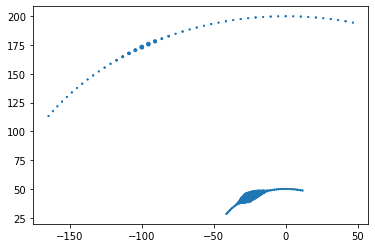

In [2]:
rh = RoundHill()
X = rh.experiments[0].X
Y = rh.experiments[0].Y #scaling
boundary = proposeboundary(X)
boundary[0][2]=-30 #puts the source on the grid!
boundary[0][0]=-120 #add two minutes to start

dist = np.round(X[:,2]**2+X[:,3]**2).astype(int)
keep = dist==10000 #2500, 10000, 40000
Xtest = X[keep,:]
Ytest = Y[keep]
X = X[~keep,:]
Y = Y[~keep]
plt.scatter(X[:,2],X[:,3],Y/10+1)

In [3]:
np.array(boundary[1])-np.array(boundary[0])

array([780., 254., 248.])

In [4]:
#set up our model...
N_feat = 3000 #10000 #Number of features used to infer the source
Nparticles = 10
#k = EQ(np.array([50,12,12]), 1000)
#k = EQ(np.array([50,10,10]), 1000)
k = EQ(np.array([50,10,10]), 200)
res = [80,60,70]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
print("Memory usage in grid model: %0.2f Gb" % gbs)
#assert gbs<6, "TOO BIG :("
noiseSD = 0.1
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(rh.experiments[0].windX,rh.experiments[0].windY)
k_0 = 1
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
mInfer.computeModelRegressors(Nparticles=Nparticles) # Compute regressor matrix
print("Computed Regressors")
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

Nsamps = 5
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
scaleby = [8,1,1]    
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]].transpose([1,2,3,0])
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)

#concmean,concvar = mInfer.computeConcentration(meanZ,covZ,Nsamps=5,Nparticles=25,interpolateSource=True)


concmean,concvar,concentrations = mInfer.computeConcentration(Nparticles=Nparticles,Zs=Zs,interpolateSource=True,coords=coords)

gridsource = mInfer.getGridCoord(np.array([0,0,0])) #location of ground truth source
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby) #grid-coords of X (inputs)
mInferCoords = mInfer.coords

testsensors = FixedSensorModel(Xtest,3)
particles = mInfer.genParticlesFromObservations(10,testsensors)#[:,:,:]#.transpose([3,0,1,2,4])
meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=Zs,interpolateSource=True)

Memory usage in grid model: 0.60 Gb
Initialising particles...
Computed Regressors
Computing SS...
Inverting SS...
Computing meanZ
Done


<ipython-input-4-d0fc08780a1a>:24: RuntimeWarning: covariance is not positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
Initialising particles...
(10, 60, 70, 3)
(10, 10, 60, 70, 3)
Particle shape:
(10, 10, 60, 70, 3)
Diffusing particles...
Initialising particles...
Particle shape:
(10, 117, 3)
Diffusing particles...


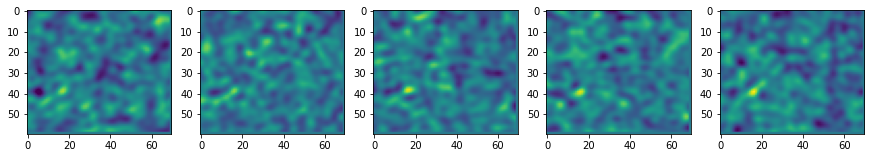

In [5]:
plt.figure(figsize=[15,5])
for i,s in enumerate(sources):
    plt.subplot(1,5,i+1)
    plt.imshow(s[10,:,:])#sources[1,10,:,:])
    plt.clim([-45,65])
    #if i==4: plt.colorbar()

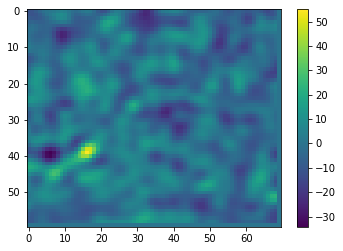

In [6]:
plt.imshow(sourcemean[10,:,:])
plt.colorbar()

In [7]:
meanobs.shape

(117,)

In [8]:
import pickle
#pickle.dump([gridsource,gridX,mInferCoords,testsensors,particles,meanobs,varobs,obs,mInfer],open('cache5smaller.pkl','wb'))
#gridsource,gridX,mInferCoords,testsensors,particles,meanobs,varobs,obs,mInfer = pickle.load(open('cache5smaller.pkl','rb'))


23


/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


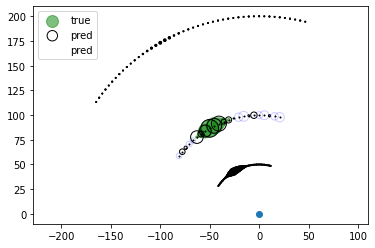

In [9]:
keep = Xtest[:,1]==600
print(sum(keep))
plt.scatter(Xtest[keep,2],Xtest[keep,3],Ytest[keep],c='green',alpha=0.5,label='true')
plt.scatter(Xtest[keep,2],Xtest[keep,3],meanobs[keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],-meanobs[keep],alpha=0.2,c='none',edgecolors='b',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],1,c='k')
plt.scatter(X[:,2],X[:,3],1+Y/20,c='k')
plt.plot([0],[0],'o')
plt.axis('equal')
plt.legend()

In [10]:
from advectionGP.kernels import meshgridndim
Xnonneg = meshgridndim(mInfer.boundary,10,True)

In [11]:
Xnonneg.shape

(1000, 3)

In [37]:
from advectionGP.constraints import NonNegConstraint
nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=5,jitter=1e-8,verbose=True,burnin=5,usecaching=False)#,startpointnormalised=True)
samps = nnc.sample(5)

#print("Checking convergence. Gelman Rubin statistic: (should be less than about 1.2)")
#print(nnc.check_convergence(Nchains=5))

Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Finding Start Point
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
   29/   30 [samples]


In [38]:
#particles = mInfer.genParticlesFromObservations(100,testsensors)[None,None,:,:,:]
#meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=np.mean(samps,0)[None,:],interpolateSource=True)

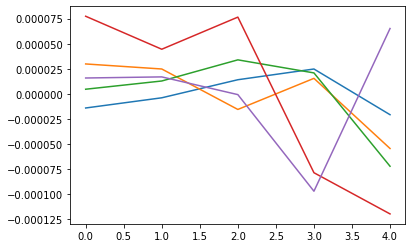

In [39]:
plt.plot(samps[:,::600]-np.mean(samps[:,::600],0));

In [40]:
#for samp in samps:
#    particles = mInfer.genParticlesFromObservations(100,testsensors)[None,None,:,:,:]
#    meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=samp[None,:],interpolateSource=True)
#    break

In [ ]:
sourcesNoNeg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in samps])
#sourcesNoNeg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in np.mean(samps,0)[None,:]])
sourcemean = np.mean(sourcesNoNeg,0)
sourcevar = np.var(sourcesNoNeg,0)    

cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...


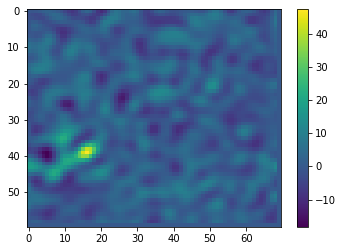

In [17]:
plt.imshow(sourcesNoNeg[-1,10,:,:])
plt.colorbar()

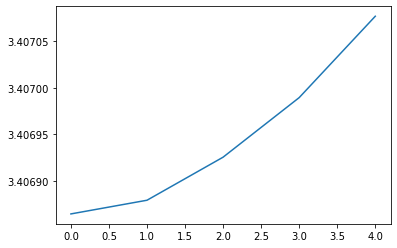

In [18]:
plt.plot(np.mean(np.abs(sourcesNoNeg),axis=(1,2,3)))

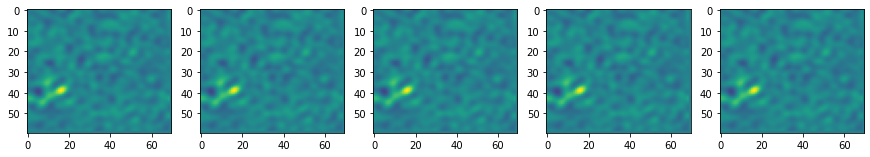

In [21]:
plt.figure(figsize=[15,5])
for i,s in enumerate(sourcesNoNeg):
    plt.subplot(2,5,i+1)
    plt.imshow(s[10,:,:])#sources[1,10,:,:])
    plt.clim([-35,45])
    #if i==4: plt.colorbar()

In [22]:
[np.unique(t) for t in mInfer.getGridCoord(Xnonneg).T]

[array([ 0,  8, 17, 26, 35, 44, 53, 62, 71, 79]),
 array([ 0,  6, 13, 19, 26, 33, 39, 46, 53, 59]),
 array([ 0,  7, 15, 23, 31, 38, 46, 54, 62, 69])]

(-40.0, 60.0)

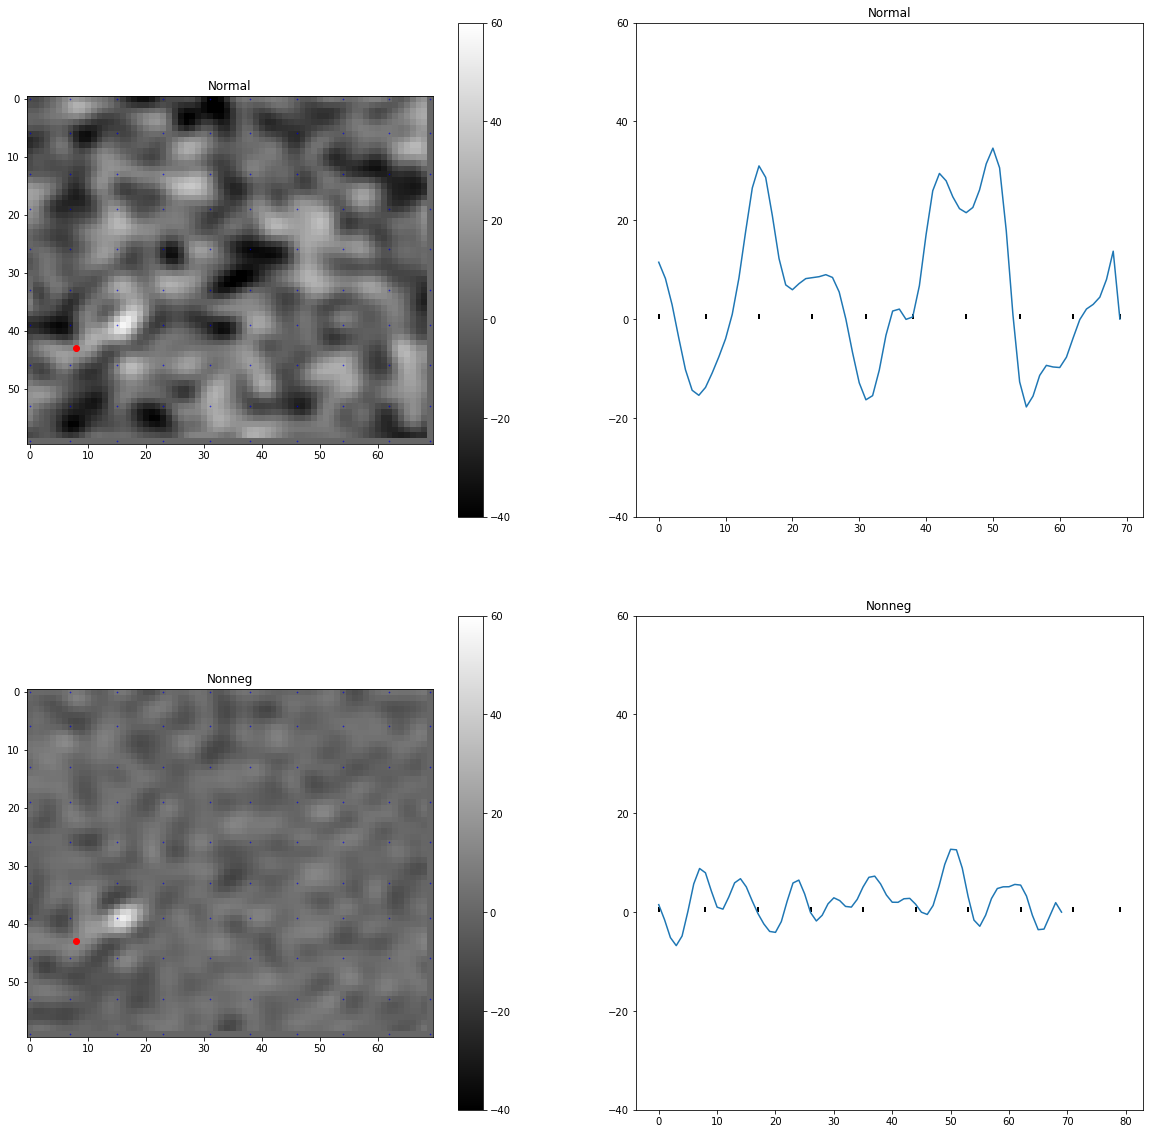

In [24]:
slicepoint = [15,21]
plt.figure(figsize=[20,20])
plt.subplot(2,2,1)
plt.title('Normal')
plt.imshow(sources[0][slicepoint[0],:,:],cmap='gray')
plt.clim([-40,60])
plt.colorbar()
plt.plot(mInfer.getGridCoord(Xnonneg)[:,2],mInfer.getGridCoord(Xnonneg)[:,1],'.b',alpha=0.1,markersize=1)
realsourcegridpos = mInfer.getGridCoord(np.array([[0,0,0]]))
plt.plot(realsourcegridpos[0][2],realsourcegridpos[0][1],'or')
plt.subplot(2,2,2)
plt.title('Normal')
plt.plot(sources[0][slicepoint[0],slicepoint[1],:])
plt.vlines(mInfer.getGridCoord(Xnonneg)[:,2],0,1)
plt.ylim([-40,60])
plt.subplot(2,2,3)
plt.title('Nonneg')
plt.imshow(sourcesNoNeg[0][slicepoint[0],:,:],cmap='gray')
plt.clim([-40,60])
plt.colorbar()
plt.plot(mInfer.getGridCoord(Xnonneg)[:,2],mInfer.getGridCoord(Xnonneg)[:,1],'.b',alpha=0.1,markersize=1)
realsourcegridpos = mInfer.getGridCoord(np.array([[0,0,0]]))
plt.plot(realsourcegridpos[0][2],realsourcegridpos[0][1],'or')
plt.subplot(2,2,4)
plt.title('Nonneg')
plt.plot(sourcesNoNeg[0][slicepoint[0],slicepoint[1],:].T)
plt.vlines(mInfer.getGridCoord(Xnonneg)[:,0],0,1)
plt.ylim([-40,60])


In [28]:
testsensors = FixedSensorModel(Xtest,3)
particles = mInfer.genParticlesFromObservations(10,testsensors)#[:,:,:]#.transpose([3,0,1,2,4])
meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=samps,interpolateSource=True)


Initialising particles...
Particle shape:
(10, 117, 3)
Diffusing particles...


In [35]:
samps

array([[ 0.4,  0.3, -0.5, ...,  0.2, -0.2,  0.2],
       [ 0.4,  0.3, -0.5, ...,  0.2, -0.2,  0.2],
       [ 0.4,  0.3, -0.5, ...,  0.2, -0.2,  0.2],
       [ 0.4,  0.3, -0.5, ...,  0.2, -0.2,  0.2],
       [ 0.4,  0.3, -0.5, ...,  0.2, -0.2,  0.2]])

23


/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


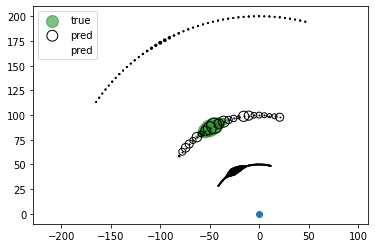

In [29]:

keep = Xtest[:,1]==600
print(sum(keep))
plt.scatter(Xtest[keep,2],Xtest[keep,3],Ytest[keep],c='green',alpha=0.5,label='true')
plt.scatter(Xtest[keep,2],Xtest[keep,3],meanobs[keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],-meanobs[keep],alpha=0.2,c='none',edgecolors='b',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],1,c='k')
plt.scatter(X[:,2],X[:,3],1+Y/20,c='k')
plt.plot([0],[0],'o')
plt.axis('equal')
plt.legend()

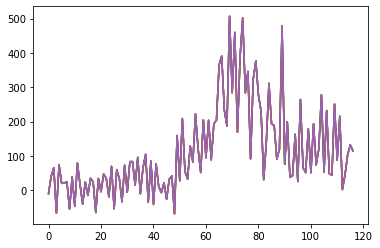

In [34]:
plt.plot(obs.T);